In [15]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from system_dynamics import Sys_dynamics

In [16]:
sys_dynamics = Sys_dynamics() # instantiation

# training data    
num_data = 2000

u_b = 15*np.pi/180

n_state = 3
n_control = 1
dt = 0.001
n_nn = 10


x_b1 = 15*np.pi/180
x_b2 = 90*np.pi/180


uc_rand = np.random.uniform(-u_b,u_b,(num_data,n_control))
x1_rand = np.random.uniform(-x_b1,x_b1,(num_data,1))
x2_rand = np.random.uniform(-x_b2,x_b2,(num_data,1))
x3_rand = np.random.uniform(-u_b,u_b,(num_data,1))


x_rand = np.concatenate((x1_rand,x2_rand,x3_rand),axis = 1)
m_input_rand = np.concatenate((x_rand,uc_rand), axis= 1)


x_next_rand = np.zeros((num_data,n_state))


for i in range(num_data):
    uc = uc_rand[i]
    x_in = x_rand[i]
    x_next_rand[i,:]= sys_dynamics.missile(x_in,uc,dt)


print(m_input_rand.shape, '\n\n', x_next_rand.shape)
print(m_input_rand[0])

(2000, 4) 

 (2000, 3)
[-0.03318037  1.23993266  0.06094141  0.00490897]


In [17]:
class Model(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()
        self.linear1 = torch.nn.Linear(n_input, n_hidden, bias=False)
        self.linear2 = torch.nn.Linear(n_hidden, n_hidden, bias=False)
        self.linear3 = torch.nn.Linear(n_hidden, n_output, bias=False)

        # self.linear1.weight.data.uniform_(-0.5, 0.5)   # initialization
        # self.linear2.weight.data.uniform_(-0.5, 0.5)   # initialization
        # self.linear3.weight.data.uniform_(-0.5, 0.5)   # initialization
    def forward(self, x):
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        x = torch.tanh(x)
        output = self.linear3(x)
        return output


model = Model(n_input=n_state+n_control, n_hidden=n_nn, n_output=n_state)

In [18]:

# training
learning_rate = 1e-2
num_epochs = 1000

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


# data feed one by one
def train_loop(x_input, x_next_label, model, loss_fn, optimizer):
    for i in range(num_data):
        x = torch.tensor(x_input[i], dtype=torch.float32)
        y = torch.tensor(x_next_label[i], dtype=torch.float32)
        # Compute prediction and loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('loss:', loss.item())


# batch training (data size as batch size)
def train_loop_batch(x_input, x_next_label, model, loss_fn, optimizer, epoch):
    x = torch.tensor(x_input, dtype=torch.float32)
    y = torch.tensor(x_next_label, dtype=torch.float32)
    # Compute prediction and loss
    pred = model(x)
    loss = loss_fn(pred, y)
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('loss:', loss.item(),'epoch:', epoch)

# training loop
for epoch in range(num_epochs):
    train_loop_batch(m_input_rand, x_next_rand, model, loss_fn, optimizer,epoch)



loss: 0.2627723217010498 epoch: 0
loss: 0.23175351321697235 epoch: 1
loss: 0.20255185663700104 epoch: 2
loss: 0.175165057182312 epoch: 3
loss: 0.14958027005195618 epoch: 4
loss: 0.12585264444351196 epoch: 5
loss: 0.10408267378807068 epoch: 6
loss: 0.08433281630277634 epoch: 7
loss: 0.06662937253713608 epoch: 8
loss: 0.051101647317409515 epoch: 9
loss: 0.0380539745092392 epoch: 10
loss: 0.027890924364328384 epoch: 11
loss: 0.02097705937922001 epoch: 12
loss: 0.017483513802289963 epoch: 13
loss: 0.017229320481419563 epoch: 14
loss: 0.01955987699329853 epoch: 15
loss: 0.02334020473062992 epoch: 16
loss: 0.027129532769322395 epoch: 17
loss: 0.02958139218389988 epoch: 18
loss: 0.029933135956525803 epoch: 19
loss: 0.02819601446390152 epoch: 20
loss: 0.024958081543445587 epoch: 21
loss: 0.021046796813607216 epoch: 22
loss: 0.01724657602608204 epoch: 23
loss: 0.014129134826362133 epoch: 24
loss: 0.011988656595349312 epoch: 25
loss: 0.010856573469936848 epoch: 26
loss: 0.010567301884293556 epoc

In [19]:

# Testing
num_data = 500 # for test
uc_rand = np.random.uniform(-u_b,u_b,(num_data,n_control))
x1_rand = np.random.uniform(-x_b1,x_b1,(num_data,1))
x2_rand = np.random.uniform(-x_b2,x_b2,(num_data,1))
x3_rand = np.random.uniform(-u_b,u_b,(num_data,1))


x_rand = np.concatenate((x1_rand,x2_rand,x3_rand),axis = 1)
m_input_rand = np.concatenate((x_rand,uc_rand), axis= 1)


x_next_rand = np.zeros((num_data,n_state))


for i in range(num_data):
    uc = uc_rand[i]
    x_in = x_rand[i]
    x_next_rand[i,:]= sys_dynamics.missile(x_in,uc,dt)


m_input_tensor = torch.tensor(m_input_rand, dtype=torch.float32)
x_next_pred = model(m_input_tensor).detach().numpy()
print('test x_next_label: \n', x_next_rand[:5])
print('x_next prediction: \n', x_next_pred[:5])


test x_next_label: 
 [[-0.11017072 -1.1780377  -0.22049622]
 [-0.11396485 -0.57706465 -0.01296651]
 [ 0.01511429  0.49394461 -0.04705128]
 [ 0.19443218 -0.4132857   0.02302871]
 [-0.1303837  -0.43453542 -0.09275931]]
x_next prediction: 
 [[-0.10477056 -1.1700313  -0.21111175]
 [-0.11845784 -0.59739333 -0.0134936 ]
 [ 0.01546531  0.51176834 -0.04825284]
 [ 0.20189536 -0.42592806  0.02405879]
 [-0.13556184 -0.44842702 -0.09482613]]


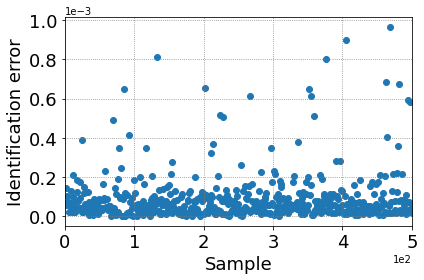

In [26]:
font_size = 18
rms = (np.mean((x_next_pred-x_next_rand)**2,axis=1))

idx_sample = np.linspace(1,num_data,num_data)

fig = plt.figure()

plt.scatter(idx_sample,rms)

plt.xlabel('Sample',fontsize = font_size)
plt.ylabel('Identification error',fontsize = font_size)
plt.xticks(fontsize = font_size)
plt.yticks(fontsize = font_size)
plt.xlim(0, num_data)
plt.grid(color='gray', linestyle=':')
plt.ticklabel_format(axis="both", style="sci", scilimits=(0,0)) 
##

plt.tight_layout()
plt.savefig('./figures/model_error_nl.pdf', format='pdf', dpi=1000, bbox_inches = 'tight')


In [ ]:
# torch.save(model.state_dict(), "model.pkl")